# Imports

In [24]:
# %% Imports
import lightning as L
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import summarize
import torch
import numpy as np
from data_utils.datamodules import SimpleMicroDataModule, AlignedMicroDataModule
from models import CNNTransformer, Transformer, TCN_classifier, TemporalConvRNN, Seq2SeqRNN
import data_utils.augmentations as augs
import csv

import os
import sys
sys.path.append('..')
from alignment import alignment_utils as utils
from alignment.AlignCCA import AlignCCA

# Define data module

In [2]:
data_filename = os.path.expanduser('../data/pt_decoding_data_S62.pkl')
# data_filename = ('../data/pt_decoding_data_S62.pkl')
pt_data = utils.load_pkl(data_filename)

In [3]:
pt_data.keys() 

dict_keys(['S14', 'S26', 'S23', 'S33', 'S22', 'S39', 'S58', 'S62'])

In [4]:
pt_data['S14'].keys()

dict_keys(['ID', 'X1', 'X1_map', 'y1', 'X2', 'X2_map', 'y2', 'X3', 'X3_map', 'y3', 'y_full_phon', 'X_collapsed', 'y_phon_collapsed', 'y_artic_collapsed', 'pre_pts'])

In [5]:
pt_data['S14']['y_full_phon'].shape

(144, 3)

In [6]:
single_trial_single_chan_X1 = pt_data['S14']['X1'][0][:,0]
single_trial_single_chan_X2 = pt_data['S14']['X2'][0][:,0]
single_trial_single_chan_X3 = pt_data['S14']['X3'][0][:,0]

import numpy as np

def find_best_overlap(a, b, min_overlap=20, tol=0.9):
    """
    Find the best overlap length between the end of a and start of b
    using correlation. Returns the overlap length and correlation.
    
    Args:
        a, b: numpy arrays (1D sequences)
        min_overlap: minimum length of overlap to consider
        tol: correlation threshold (0–1)
    """
    max_overlap = min(len(a), len(b))
    best_corr, best_len = -1, 0

    for i in range(min_overlap, max_overlap + 1):
        seg_a = a[-i:]
        seg_b = b[:i]
        corr = np.corrcoef(seg_a, seg_b)[0, 1]
        if corr > best_corr:
            best_corr, best_len = corr, i

    return best_len if best_corr >= tol else 0, best_corr


def merge_two(a, b, name_a="A", name_b="B", min_overlap=20, tol=0.9):
    """
    Merge two sequences by finding overlap using correlation.
    Returns merged sequence and overlap length.
    """
    overlap_len, corr = find_best_overlap(a, b, min_overlap=min_overlap, tol=tol)
    print(f"Overlap between {name_a} and {name_b}: {overlap_len} (corr={corr:.3f})")
    merged = np.concatenate([a, b[overlap_len:]])
    return merged, overlap_len


def merge_with_overlap(arrays, names=None, min_overlap=20, tol=0.9):
    """
    Recursively merge a list of sequences by correlation-based overlap.
    """
    if names is None:
        names = [f"X{i+1}" for i in range(len(arrays))]
    if len(arrays) == 1:
        return arrays[0], 0
    elif len(arrays) == 2:
        return merge_two(arrays[0], arrays[1], names[0], names[1], 
                         min_overlap=min_overlap, tol=tol)
    else:
        merged_first_two, _ = merge_two(arrays[0], arrays[1], 
                                        names[0], names[1], 
                                        min_overlap=min_overlap, tol=tol)
        return merge_with_overlap([merged_first_two] + arrays[2:], 
                                  [names[0] + names[1]] + names[2:], 
                                  min_overlap=min_overlap, tol=tol)

# Example usage
merged_signal, overlap_len = merge_with_overlap([
    single_trial_single_chan_X1,
    single_trial_single_chan_X2,
    single_trial_single_chan_X3
])


Overlap between X1 and X2: 170 (corr=0.998)
Overlap between X1X2 and X3: 159 (corr=0.998)


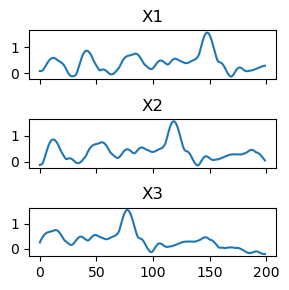

In [7]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(3, 3), sharex=True)

axs[0].plot(single_trial_single_chan_X1)
axs[0].set_title("X1")

axs[1].plot(single_trial_single_chan_X2)
axs[1].set_title("X2")

axs[2].plot(single_trial_single_chan_X3)
axs[2].set_title("X3")

plt.tight_layout()
plt.show()

Merged signal has length 271.


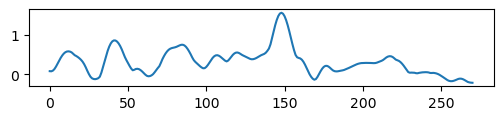

In [8]:
plt.figure(figsize=(6, 1))
plt.plot(merged_signal)

print(f'Merged signal has length {len(merged_signal)}.')

In [ ]:
pt = 'S14'
p_ind = 1
lab_type = 'phon'
algn_type = 'phon_seq'
tar_data, pre_data = utils.decoding_data_from_dict(pt_data, pt, p_ind,
                                                   lab_type=lab_type,
                                                   algn_type=algn_type)
print([d.shape for d in tar_data])
print([[d.shape for d in p] for p in pre_data])

[(144, 200, 111), (144,), (144, 3)]
[[(148, 200, 111), (148,), (148, 3)], [(151, 200, 63), (151,), (151, 3)], [(46, 200, 149), (46,), (46, 3)], [(151, 200, 74), (151,), (151, 3)], [(137, 200, 144), (137,), (137, 3)], [(141, 200, 171), (141,), (141, 3)], [(178, 200, 201), (178,), (178, 3)]]


In [36]:
!du -sh ~/.conda ~/.cache ~/.local 2>/dev/null

1.4G	/hpc/home/mw582/.conda
292K	/hpc/home/mw582/.cache
6.4G	/hpc/home/mw582/.local


In [12]:
!df -h ~

Filesystem                                               Size  Used Avail Use% Mounted on
oit-nas-fe13.dscr.duke.local:/ifs/oit-nas-fe13/hpc-home   25G   14G   12G  54% /hpc/home


In [13]:
rm -rf ~/.local/share/jupyter/runtime/*

In [35]:
rm -rf ~/.local/share/Trash/*

In [36]:
rm -rf ~/.cache/*

In [33]:
# fold_data_path = '.'

fs = 200 # Hz
# augmentations = [augs.time_warping, augs.time_masking, augs.time_shifting, augs.noise_jitter, augs.scaling]
augmentations = [augs.time_shifting, augs.noise_jitter, augs.scaling]
# augmentations = None
# data = torch.rand(n_samples, n_timepoints, n_features)
# labels = torch.randint(0, 9, (n_samples,))
# data = torch.Tensor(all_pt_dict['S14']['X1'])
# labels = torch.Tensor(all_pt_dict['S14']['y1']).long() - 1
data = torch.Tensor(tar_data[0])
labels = torch.Tensor(tar_data[1]).long().unsqueeze(1) - 1
align_labels = torch.Tensor(tar_data[2]).long() - 1
# pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[1]).long().unsqueeze(1) - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]
pool_data = [(torch.Tensor(p[0]), torch.Tensor(p[2]).long() - 1, torch.Tensor(p[2]).long() - 1) for p in pre_data]  # for seq2seq RNN
# data = torch.Tensor(all_pt_dict['S14']['X_collapsed'])
# labels = torch.Tensor(all_pt_dict['S14']['y_phon_collapsed']).long() - 1

In [35]:
import os

def folds_exist(path, n_folds):
    for i in range(n_folds):
        f = os.path.join(path, f"fold_data/fold_{i}.h5")
        if not os.path.exists(f):
            print("❌ Missing:", f)
            return False
    return True

batch_size = 500
n_folds = 20
val_size = 0.1
context_prefix = "pooled"
fold_data_path = os.path.expanduser('../data/training_data' + context_prefix)

if folds_exist(fold_data_path, n_folds):
    print("✅ All folds found, reusing existing DataModule...")
    dm = AlignedMicroDataModule(
        data, align_labels, align_labels, pool_data, AlignCCA,
        batch_size=batch_size, folds=n_folds, val_size=val_size,
        augmentations=augmentations, data_path=fold_data_path
    )
    # ⚠️ don't call dm.setup() — it would regenerate everything
else:
    print("⚙️ Generating new folds...")
    dm = AlignedMicroDataModule(
        data, align_labels, align_labels, pool_data, AlignCCA,
        batch_size=batch_size, folds=n_folds, val_size=val_size,
        augmentations=augmentations, data_path=fold_data_path
    )
    dm.setup()

✅ All folds found, reusing existing DataModule...


In [37]:
AlignCCA

alignment.AlignCCA.AlignCCA

In [36]:
dm.train_dataloader().dataset.tensors[1].shape

torch.Size([4296, 3])

# Define model

In [38]:
from pytorch_lightning.utilities.model_summary import summarize


gclip_val = 0.5

##### Seq2Seq RNN #####
# model parameters
in_channels = data.shape[-1] # 111
num_classes = 9
n_filters = 100
# d_model = data.shape[-1]
kernel_time = 50  # ms
kernel_size = int(kernel_time * fs / 1000)  # kernel length in samples
stride_time = 50  # ms
stride = int(stride_time * fs / 1000)  # stride length in samples
padding = 0
n_enc_layers = 2
n_dec_layers = 1
hidden_size = 500
cnn_dropout = 0.3
rnn_dropout = 0.3
learning_rate = 1e-4
l2_reg = 1e-5
activ = False
model_type = 'gru'

sum_model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                       n_dec_layers, kernel_size, stride, padding, cnn_dropout,
                       rnn_dropout, model_type, learning_rate, l2_reg)

print(summarize(sum_model))

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | criterion     | CrossEntropyLoss | 0      | train
1 | temporal_conv | TemporalConv     | 111 K  | train
2 | encoder       | EncoderRNN       | 6.3 M  | train
3 | decoder       | DecoderRNN       | 1.5 M  | train
-----------------------------------------------------------
7.9 M     Trainable params
0         Non-trainable params
7.9 M     Total params
31.743    Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


/hpc/home/mw582/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(


In [39]:
data.shape[-1]

111

# Train model

In [40]:
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", "The number of training batches.*")

In [41]:
# instantiate the trainer
max_epochs = 500
# es_pat = max_steps // 20
# max_steps = 500
es_pat = 50
warmup = 100
# callbacks = [EarlyStopping(monitor='val_loss', patience=10)]
log_dir = os.path.expanduser('~/workspace/transformer_data/transformer_logs')

In [42]:
# class MetricCollector(L.Callback):
#     def __init__(self):
#         self.metrics = {}
#     
#     def on_validation_epoch_end(self, trainer, pl_module):
#         self.metrics['val_loss'] = trainer.logger.metrics['val_loss']
#         self.metrics['val_acc'] = trainer.logger.metrics['val_acc']
#     
#     def on_test_epoch_end(self, trainer, pl_module):
#         self.metrics['test_loss'] = trainer.logger.metrics['test_loss']
#         self.metrics['test_acc'] = trainer.logger.metrics['test_acc']

In [43]:
from torchmetrics.functional.classification import multiclass_confusion_matrix

def cmat_acc(y_hat, y, num_classes):
    y_pred = torch.argmax(y_hat, dim=1)
    cmat = multiclass_confusion_matrix(y_pred, y, num_classes)
    acc_cmat = cmat.diag().sum() / cmat.sum()
    return acc_cmat

In [ ]:
acc_dir = os.path.expanduser('~/workspace/transformer_data/accs/')

# train the model
n_iters = 20
iter_accs = []
for i in range(n_iters):
    print(f'##### Setting up data module for iteration {i+1} #####')
    dm.setup()
    
    fold_accs = []
    # y_pred_all = []
    # y_test_all = []
    for fold in range(n_folds):
        # if fold > 1:
        #     break
        dm.set_fold(fold)
        # print(dm.current_fold)
        
        # instantiate the model
        in_channels = dm.get_data_shape()[-1]
        # print(in_channels)
        # model = CNNTransformer(in_channels, num_classes, d_model, kernel_size, stride, padding,
        #                        n_head, num_layers, dim_fc, cnn_dropout, tform_dropout, learning_rate,
        #                        warmup, max_steps, l2_reg, activation=activ)
        # model = TCN_classifier(in_channels, num_classes, dim_fc, kernel_size, stride, padding,
        #                            cnn_dropout, learning_rate, l2_reg, activation=activ)
        # model = TemporalConvRNN(in_channels, n_filters, num_classes, hidden_size, n_layers,
                                # kernel_size, dim_fc, stride, padding, cnn_dropout,
                                # rnn_dropout, learning_rate, l2_reg, activation=activ,
                                # decay_iters=max_epochs)
        model = Seq2SeqRNN(in_channels, n_filters, hidden_size, num_classes, n_enc_layers,
                           n_dec_layers, kernel_size, stride, padding, cnn_dropout, rnn_dropout, model_type,
                           learning_rate, l2_reg, activation=activ, decay_iters=max_epochs)
        
        # model.current_fold = fold
        callbacks = [
            # ModelCheckpoint(monitor='val_loss', mode='min'),
            ModelCheckpoint(monitor='val_acc', mode='max'),
            # EarlyStopping(monitor='val_loss', patience=es_pat),
            LearningRateMonitor(logging_interval='epoch'),
            ]
        trainer = L.Trainer(default_root_dir=log_dir,
                            max_epochs=max_epochs,
                            # max_steps=max_steps,
                            gradient_clip_val=gclip_val,
                            accelerator='auto',
                            callbacks=callbacks,
                            logger=True,
                            enable_model_summary=False,
                            enable_progress_bar=False,
                           )
        # # trainer.fit(model, dm)
        trainer.fit(model=model, train_dataloaders=dm.train_dataloader(), val_dataloaders=dm.val_dataloader())
        print(trainer.logged_metrics)
        # print(trainer.callback_metrics)
        # print the training metrics from the best model checkpoint
        # print(f'Fold {fold} best model metrics:')
        # print(trainer.checkpoint_callback.best_model_score)


        # trainer.test(model, dm)
        # model = CNNTransformer.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)
        trainer.test(model=model, dataloaders=dm.test_dataloader(), ckpt_path='best')
        # trainer.test(dataloaders=dm.test_dataloader(), ckpt_path='best')

        # test_pred = model(dm.test_dataloader().dataset.tensors[0])
        # test_pred = trainer.predict(model, dm.test_dataloader(), ckpt_path='best)[0]
        # test_pred = torch.argmax(test_pred, dim=1)
        # print(test_pred)
        # y_pred_all.extend(test_pred)
        # y_test_all.extend(dm.test_dataloader().dataset.tensors[1])
        
        fold_accs.append(trainer.logged_metrics['test_acc'])
    
        # save loss information
        # loss_dict = trainer.logger.metrics
        # loss_dict['fold'] = fold
        # loss_dict['model'] = model
    # acc = cmat_acc(torch.stack(y_pred_all), torch.stack(y_test_all), num_classes)
    # print(acc)
    # iter_accs.append(acc)
    # print(f'Averaged accuracy: {sum(fold_accs) / len(fold_accs)}')
    iter_accs.append(fold_accs)
    with open(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs_iter{i+1}.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerows(iter_accs)
    print(np.mean(fold_accs))
# print(sum(iter_accs) / len(iter_accs), iter_accs)
print(iter_accs)
with open(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerows(iter_accs)
np.save(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs.npy'), np.array(iter_accs))

##### Setting up data module for iteration 1 #####


/hpc/home/mw582/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX 5000 Ada Generation') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer

{'train_loss': tensor(0.0003), 'train_acc': tensor(1.), 'val_loss': tensor(5.9037), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=5-step=54.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    1.8837624788284302     │
└───────────────────────────┴───────────────────────────┘

/hpc/home/mw582/.local/lib/python3.11/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/hpc/home/mw582/.local/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:751: Checkpoint directory /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90.ckpt


{'train_loss': tensor(0.0002), 'train_acc': tensor(1.), 'val_loss': tensor(5.0095), 'val_acc': tensor(0.4286)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    1.9619132280349731     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=71-step=648.ckpt


{'train_loss': tensor(0.0004), 'train_acc': tensor(1.), 'val_loss': tensor(4.7721), 'val_acc': tensor(0.4762)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=71-step=648.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │     4.645332336425781     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=10-step=99.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=10-step=99.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


{'train_loss': tensor(0.0002), 'train_acc': tensor(1.), 'val_loss': tensor(5.2132), 'val_acc': tensor(0.3095)}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5416666865348816     │
│         test_loss         │    1.7710142135620117     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=39-step=360.ckpt


{'train_loss': tensor(0.0036), 'train_acc': tensor(0.9978), 'val_loss': tensor(4.3851), 'val_acc': tensor(0.4524)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=39-step=360.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    2.5398199558258057     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=13-step=126.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=13-step=126.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


{'train_loss': tensor(0.0056), 'train_acc': tensor(0.9967), 'val_loss': tensor(3.8015), 'val_acc': tensor(0.4762)}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4761904776096344     │
│         test_loss         │     1.608087420463562     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=23-step=216.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=23-step=216.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


{'train_loss': tensor(0.0003), 'train_acc': tensor(1.), 'val_loss': tensor(4.1067), 'val_acc': tensor(0.4524)}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │      1.9743732213974      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=20-step=189.ckpt


{'train_loss': tensor(0.0004), 'train_acc': tensor(1.), 'val_loss': tensor(4.5158), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=20-step=189.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │     2.040292739868164     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90-v1.ckpt


{'train_loss': tensor(0.0003), 'train_acc': tensor(1.), 'val_loss': tensor(4.0264), 'val_acc': tensor(0.4048)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90-v1.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    1.5462969541549683     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=17-step=162.ckpt


{'train_loss': tensor(0.0016), 'train_acc': tensor(1.), 'val_loss': tensor(5.1713), 'val_acc': tensor(0.3571)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=17-step=162.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4761904776096344     │
│         test_loss         │     1.81270432472229      │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90-v2.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90-v2.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


{'train_loss': tensor(0.0003), 'train_acc': tensor(1.), 'val_loss': tensor(4.9934), 'val_acc': tensor(0.3333)}


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4285714328289032     │
│         test_loss         │    1.4472709894180298     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90-v3.ckpt


{'train_loss': tensor(0.0004), 'train_acc': tensor(1.), 'val_loss': tensor(5.4528), 'val_acc': tensor(0.3810)}


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=9-step=90-v3.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.523809552192688     │
│         test_loss         │    1.3003251552581787     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
`Trainer.fit` stopped: `max_epochs=500` reached.
Restoring states from the checkpoint path at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=41-step=378.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


{'train_loss': tensor(0.0003), 'train_acc': tensor(1.), 'val_loss': tensor(4.3545), 'val_acc': tensor(0.4048)}


Loaded model weights from the checkpoint at /hpc/home/mw582/workspace/transformer_data/transformer_logs/lightning_logs/version_36639366/checkpoints/epoch=41-step=378.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.3333333432674408     │
│         test_loss         │    3.6274173259735107     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


# View results

In [50]:
pt = 'S14'
acc_dir = os.path.expanduser('~/workspace/transformer_data/accs/')
context_prefix = 'pooled'

In [51]:
iter_accs = np.load(os.path.join(acc_dir, f'{context_prefix}/{pt}_{context_prefix}_seq2seq_rnn_accs.npy'))
print(iter_accs.shape)
print(iter_accs.mean(axis=1))
print(iter_accs.mean())

FileNotFoundError: [Errno 2] No such file or directory: '/Users/wangmaidou/workspace/transformer_data/accs/pooled/S14_pooled_seq2seq_rnn_accs.npy'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# from torch import tensor
# test = [[tensor(0.5000), tensor(0.3636), tensor(0.2727), tensor(0.4545), tensor(0.3182), tensor(0.4545), tensor(0.4091), tensor(0.2273), tensor(0.2727), tensor(0.4091), tensor(0.2727), tensor(0.3182), tensor(0.3333), tensor(0.3333), tensor(0.4762), tensor(0.3333), tensor(0.2857), tensor(0.3810), tensor(0.3810), tensor(0.3810)]]
# plt.boxplot(iter_accs.mean(axis=1))
sns.boxplot(data=iter_accs.mean(axis=1))
sns.swarmplot(data=iter_accs.mean(axis=1), color='black')
# sns.boxplot(data=iter_accs.T)
# sns.swarmplot(data=iter_accs.T, color='black')
plt.axhline(y=1/9, color='gray', linestyle='--')
plt.ylim(0, None)
plt.show()

In [15]:
!git add .

In [16]:
!git commit -m "update from DCC Jupyter"


[main c291ecf] update from DCC Jupyter
 Committer: Maidou Wang <mw582@dcc-core-gpu-01.rc.duke.edu>
Your name and email address were configured automatically based
on your username and hostname. Please check that they are accurate.
You can suppress this message by setting them explicitly. Run the
following command and follow the instructions in your editor to edit
your configuration file:

    git config --global --edit

After doing this, you may fix the identity used for this commit with:

    git commit --amend --reset-author

 1 file changed, 123 insertions(+), 6 deletions(-)


In [17]:
!git push origin main


Enumerating objects: 27, done.
Counting objects: 100% (27/27), done.
Delta compression using up to 8 threads
Compressing objects: 100% (21/21), done.
Writing objects: 100% (22/22), 70.75 KiB | 1.33 MiB/s, done.
Total 22 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
remote: Resolving deltas: 100% (9/9), completed with 2 local objects.
remote: error: GH013: Repository rule violations found for refs/heads/main.
remote: 
remote: - GITHUB PUSH PROTECTION
remote:   —————————————————————————————————————————
remote:     Resolve the following violations before pushing again
remote: 
remote:     - Push cannot contain secrets
remote: 
remote:     
remote:      (?) Learn how to resolve a blocked push
remote:      https://docs.github.com/code-security/secret-scanning/working-with-secret-scanning-and-push-protection/working-with-push-protection-from-the-command-line#resolving-a-blocked-push
remote:     
remote:     
remote:       —— GitHub Personal Access Token ——————————————————————
remote:

In [14]:
!git reset --soft HEAD~1


In [13]:
!pip install git-filter-repo


Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 kB 1.1 MB/s eta 0:00:00a 0:00:01
